In [1]:
from __future__ import division
import sys, os
import time, datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from ripser import ripser as tda

sd=int((time.time()%1)*(2**31))
np.random.seed(sd)
curr_date=datetime.datetime.now().strftime('%Y_%m_%d')+'_'

gen_fn_dir = os.path.abspath('.') + '/shared_scripts'
sys.path.append(gen_fn_dir)

from dim_red_fns import run_dim_red
from os.path import join as pjoin
from scipy.spatial.distance import pdist
from sklearn import neighbors
from scipy.io import loadmat

# imports for spud_interactive_fit
from mpl_toolkits.mplot3d import Axes3D
# from sklearn import decomposition, manifold
import manifold_fit_and_decode_fns as mff
import fit_helper_fns as fhf
from dim_red_fns import run_dim_red # from shared_scripts


In [2]:
# Functions 
def plot_barcode(results):
    """
        Plot betti barcode results
    """
    col_list = ['r', 'g', 'm', 'c']
    h0, h1, h2 = results['h0'], results['h1'], results['h2']
    # replace the infinity bar (-1) in H0 by a really large number
    h0[~np.isfinite(h0)] = 100
    # Plot the longest barcodes only
    plot_prcnt = [99, 98, 90] # order is h0, h1, h2
    to_plot = []
    for curr_h, cutoff in zip([h0, h1, h2], plot_prcnt):
         bar_lens = curr_h[:,1] - curr_h[:,0]
         plot_h = curr_h[bar_lens > np.percentile(bar_lens, cutoff)]
         to_plot.append(plot_h)

    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(3, 4)
    for curr_betti, curr_bar in enumerate(to_plot):
        ax = fig.add_subplot(gs[curr_betti, :])
        for i, interval in enumerate(reversed(curr_bar)):
            ax.plot([interval[0], interval[1]], [i, i], color=col_list[curr_betti],
                lw=1.5)
        # ax.set_xlim([0, xlim])
        # ax.set_xticks([0, xlim])
        ax.set_ylim([-1, len(curr_bar)])
        # ax.set_yticks([])
    plt.show()

In [3]:
# path names
data_path = '/Users/joshstern/Documents/UchidaLab_NeuralData/patch_foraging_neuropix/josh/manifolds/spud_code/data'
m80_datapath = pjoin(data_path,'m80.mat')


In [4]:
# Load data.. eventually need X and var_to_decode
visualization = False
m80data = loadmat(m80_datapath)    
fr_mat = m80data['m80_fr']
score = m80data['m80_pca']
time_on_patch = m80data['m80_time']
tts = m80data['m80_tts']
zscored_prt = m80data['m80_zscored_prt']

if visualization == True:
    %matplotlib notebook
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[0,::2],X[1,::2],X[2,::2], c ='r', s=.01)
    plt.show()

# which data to use in form [n_cells n_timepoints]
X = score.T

# define variable to decode
var_to_decode = time_on_patch
    

In [7]:
# Note that we have already performed dimensionality reduction
# 2) Threshold out outlier points with low neighborhood density
# this step improves robustness to noise
# this is called nt-TDA
thrsh = True
thrsh_prcnt = 20
neigh_percentile = 0.01
if thrsh:
    # a) find number of neighbors of each point within radius of kth percentile of all
    # we decrease this to make this easier
    # pairwise dist.
    dist = pdist(X, 'euclidean')
    print("Finished Calculating Distance Matrix")
    rad = np.percentile(dist, neigh_percentile) 
    del dist
    neigh = neighbors.NearestNeighbors()
    neigh.fit(X)
    print("Finished Calculating Nearest Neighbors")
    num_nbrs = np.array(list(map(len, neigh.radius_neighbors(X=X, radius=rad,return_distance=False))))
    del neigh
    print("Finished Calculating Num Nearest Neighbors")
    
    # b) threshold out points with low density
    threshold = np.percentile(num_nbrs, thrsh_prcnt)
    X_thresholded = X[num_nbrs > threshold]
del X


Finished Calculating Distance Matrix
Finished Calculating Nearest Neighbors
Finished Calculating Num Nearest Neighbors


In [10]:
print(X_thresholded.shape)


(45134, 20)


<IPython.core.display.Javascript object>


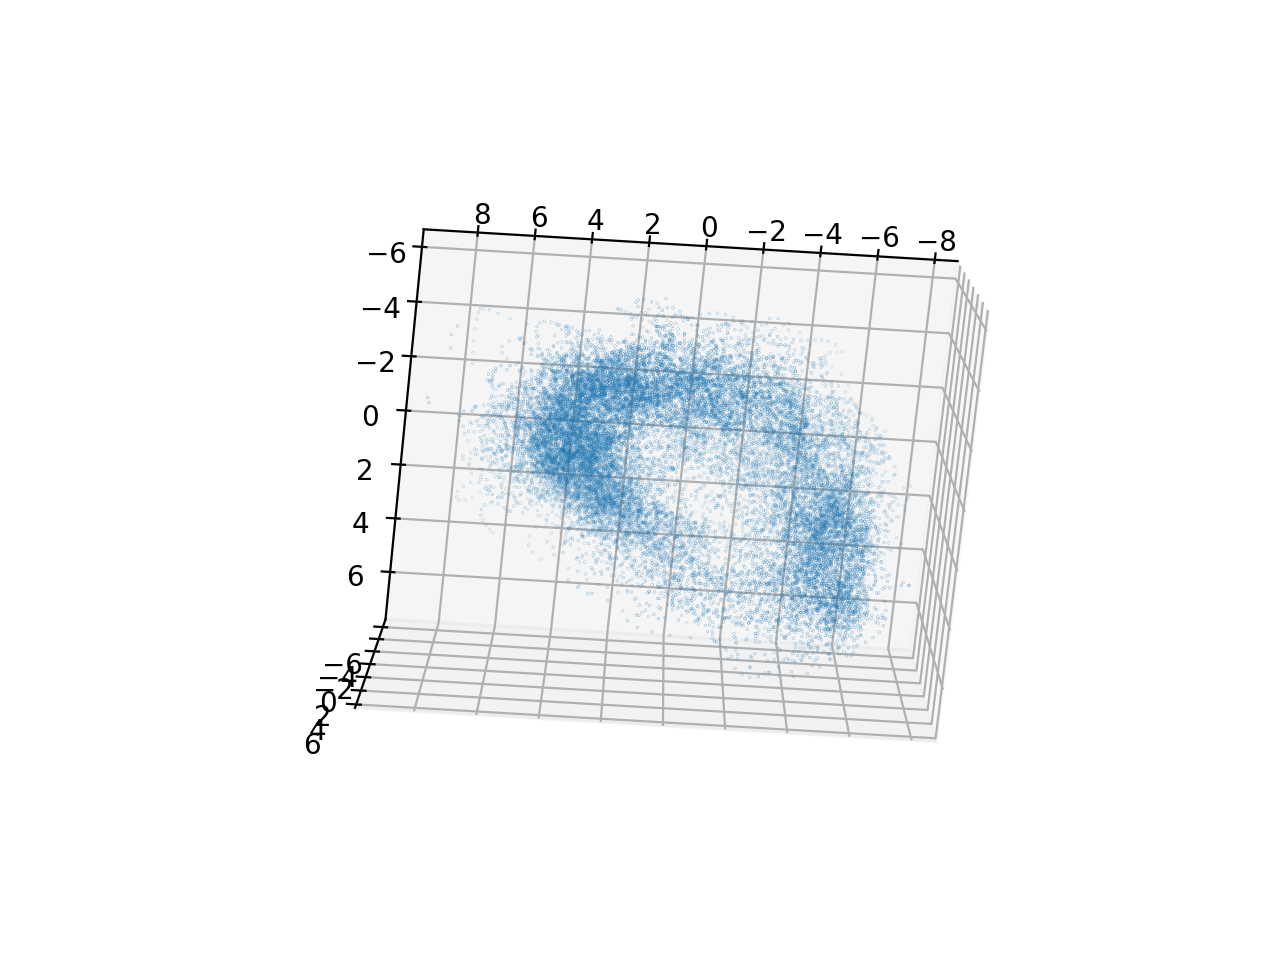

In [11]:
# Visualize what happens when we apply thresholding
%matplotlib notebook
fig = plt.figure()
ax1 = fig.add_subplot(111,projection = '3d')
ax1.scatter(X_thresholded[::2,0],X_thresholded[::2,1],X_thresholded[::2,2],s = .01)


In [ ]:
# 3) Inspect Betti barcode 
# H0 & H1
barcodes = tda(X_thresholded, maxdim=1, coeff=2)['dgms']
results['h0'] = barcodes[0]
results['h1'] = barcodes[1]

# H2. Need to subsample points for computational tractability if
# number of points is large (can go higher but very slow)
if len(X_thresholded) > 1500:
    idx = np.random.choice(np.arange(len(X_thresholded)), 1500, replace=False)
    H2_X = X_thresholded[idx]
else:
    H2_X = X_thresholded

barcodes = tda(H2_X, maxdim=2, coeff=2)['dgms']
results['h2'] = barcodes[2]
del H2_X

In [ ]:
# Visualize betti barcode
visualization = True
if visualization == True:
    plot_barcode(results)

In [ ]:
## 4) fit a spline to the manifold 
curr_mani = X_reduced # note already thresholded

# Parameters
fit_dim = 3
nKnots = 5
knot_order = 'wt_per_len'
penalty_type = 'mult_len'
make_loop = False
train_frac = 0.8

n_points = len(curr_mani)
n_train = np.round(train_frac * n_points).astype(int)

# # Use measured angles to set origin and direction of coordinate increase
# var_to_decode = embed['meas_angles']
# note that we defined var_to_decode above
fit_params = {'dalpha' : 0.005, 'knot_order' : knot_order,'penalty_type' : penalty_type, 'nKnots' : nKnots,
              'make_loop' : make_loop} # only do this if there is a ring structure!

# split training and test data
train_idx = np.random.choice(n_points, size = n_train, replace=False)
test_idx = np.array([idx for idx in range(n_points) if idx not in train_idx])
data_to_fit = curr_mani[train_idx].copy()
data_to_decode = curr_mani[test_idx].copy()
